In [1]:
from pyvela import SPNTA, pyvela_plot
import emcee
import numpy as np
import shutil
import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
spnta = SPNTA(
    parfile="NGC6440E.par",
    timfile="NGC6440E.tim",
    # custom_priors="NGC6440E_priors.json",
    cheat_prior_scale=100,
)

In [3]:
# Create the output directory and save the pre-analysis summary
result_dir = "NGC6440E_out"
if os.path.isdir(result_dir):
    shutil.rmtree(result_dir)
os.mkdir(result_dir)

spnta.save_pre_analysis_summary(result_dir)

In [4]:
nwalkers = spnta.ndim * 5
p0 = np.array(
    [spnta.prior_transform(cube) for cube in np.random.rand(nwalkers, spnta.ndim)]
)

In [5]:
spnta.lnpost_vectorized(p0)

40-element Vector{Float64}:
  -20405.01071615265
      -1.4775138684026708e6
      -2.3745369456270644e6
 -241887.79202165772
      -3.284604322736077e6
 -221531.61684400888
      -1.5889203786157507e6
  -14207.524963426331
 -124062.32047619559
      -3.622576006863828e6
       ⋮
      -5.8230127956658965e6
 -466231.89314495464
      -5.7103827291228715e6
 -436126.9209914606
      -1.444594976919778e6
  -99028.03253995853
      -1.0151986662426066e6
      -6.159151801959546e6
   -3204.8325908286242

In [6]:
sampler = emcee.EnsembleSampler(
    nwalkers, spnta.ndim, spnta.lnpost_vectorized, vectorize=True
)

In [7]:
sampler.run_mcmc(p0, 6000, progress=True);

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [00:04<00:00, 1282.15it/s]


In [8]:
samples_raw = sampler.get_chain(flat=True, discard=1000, thin=50)
samples = spnta.rescale_samples(samples_raw)

In [9]:
F_ = spnta.model.param_handler._default_params_tuple.F_.x
shifts = np.array([0 if pname != "F0" else F_ for pname in spnta.param_names])

In [10]:
params_med_raw = np.median(samples_raw, axis=0)
params_med = spnta.rescale_samples(params_med_raw)
params_std = np.std(samples, axis=0)

print(f"Param\t{'Unit':<15}{'Value':<33}Units")
print("-" * 77)
for pname, punit, pval, pstd in zip(
    spnta.param_names, spnta.param_units, (params_med + shifts), params_std
):
    print(f"{pname}\t{punit:<15}{pval}\t+/-\t{pstd}")

Param	Unit           Value                            Units
-----------------------------------------------------------------------------
RAJ	hourangle      17.814666763919437	+/-	3.961131111996723e-08
DECJ	deg            -20.358162679849233	+/-	9.628866545515939e-06
PHOFF	1              0.0983715436846476	+/-	0.00044126726364050875
DM	pc / cm3       224.1146246064201	+/-	0.03617610241643674
F0	Hz             61.48547655437065	+/-	1.8540663825891884e-11
F1	Hz / s         -1.1812878890039987e-15	+/-	1.4753435517830575e-18
EFAC1	1              1.0197353226639012	+/-	0.10250968592204691
EQUAD1	us             0.2333250569787347	+/-	4.457337975430686


In [11]:
spnta.save_results(result_dir, samples_raw)

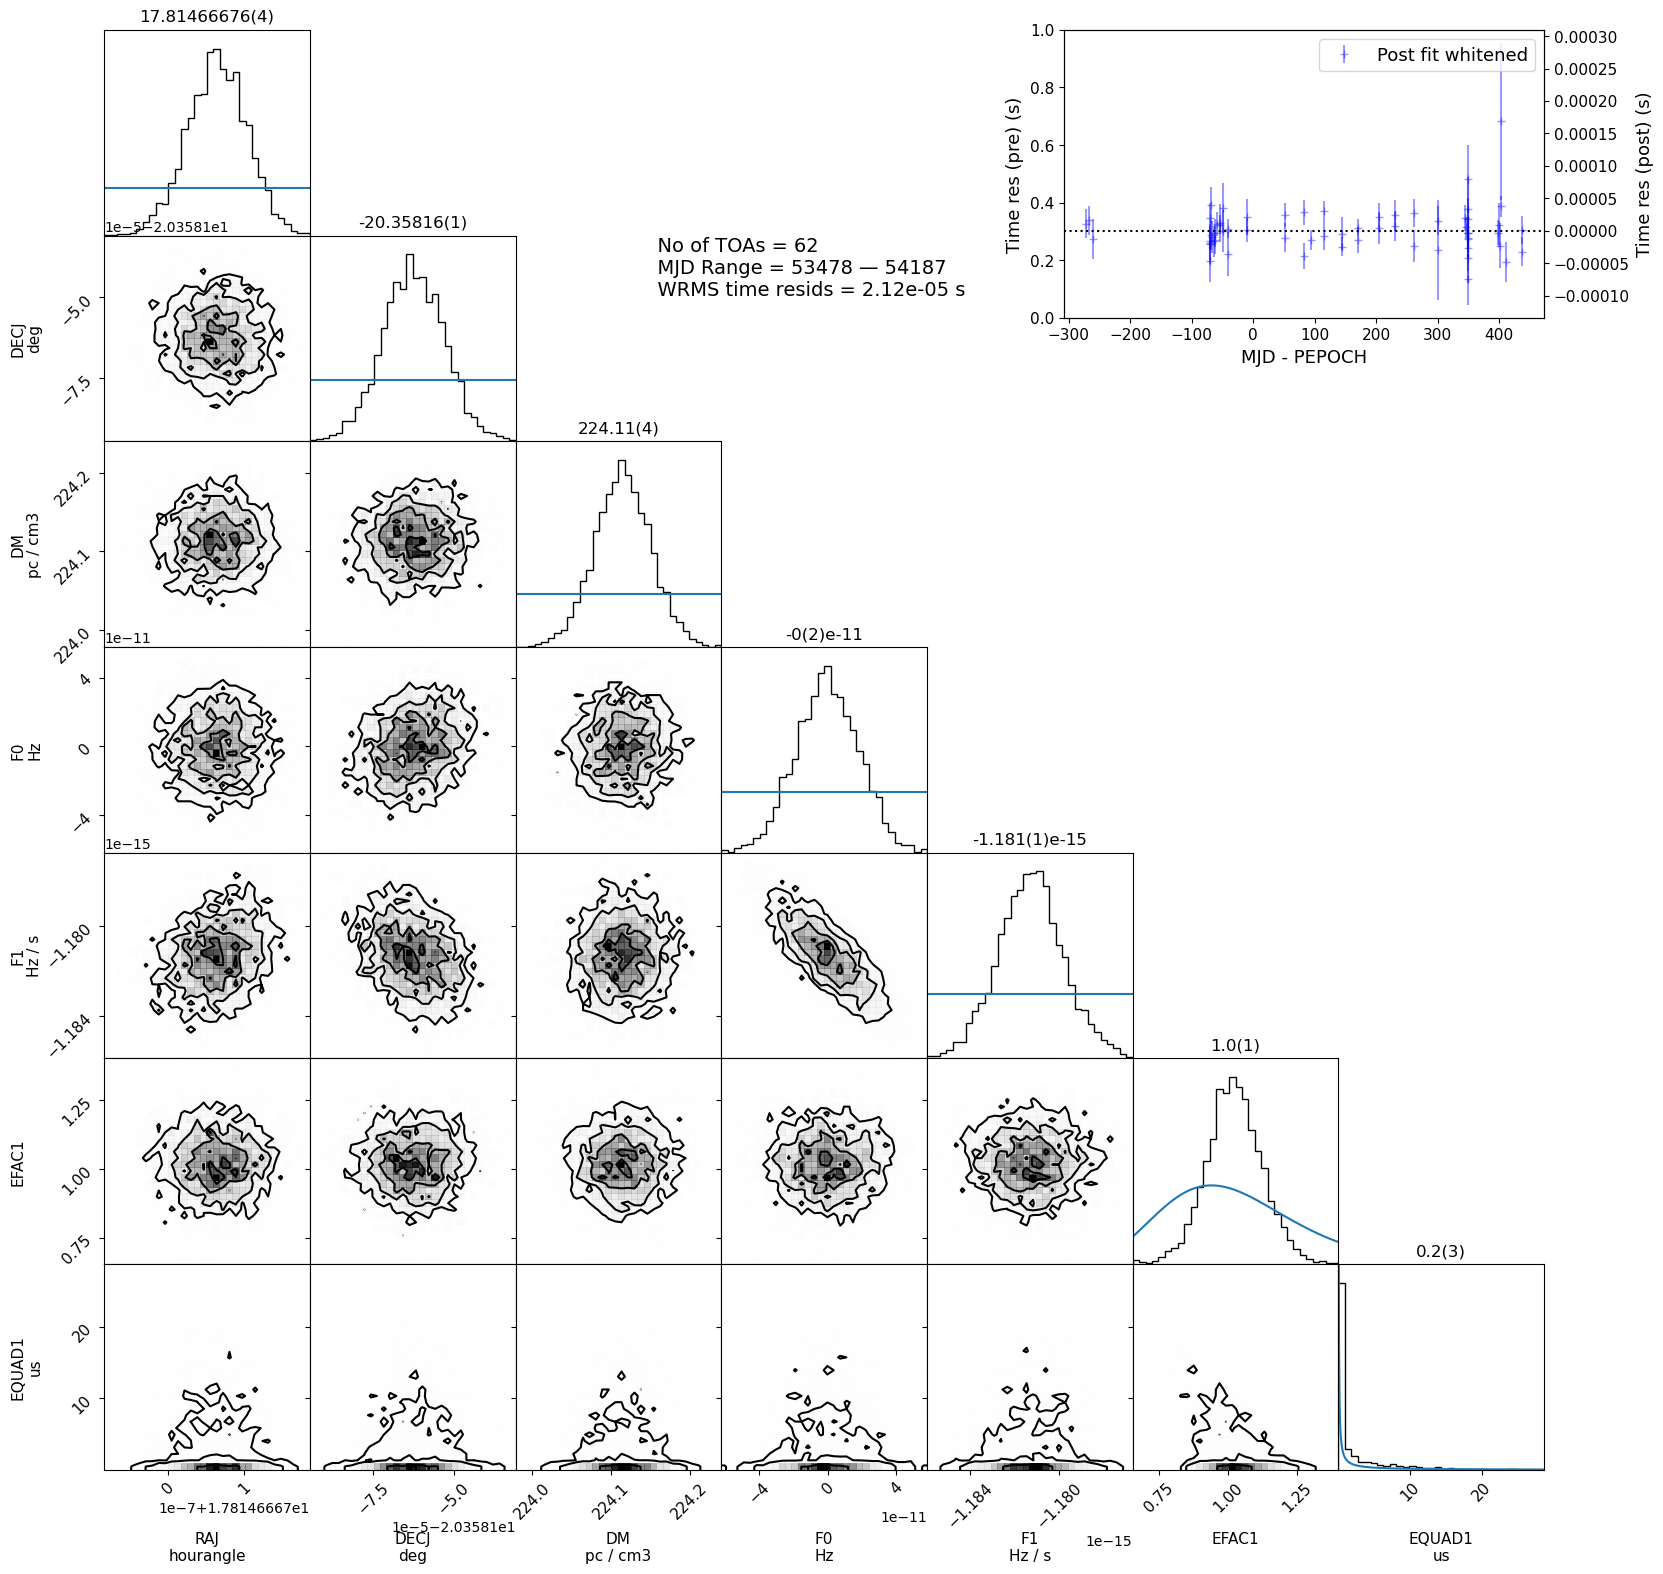

In [12]:
pyvela_plot.plot(result_dir, plot_priors=True, labelpad=0)

In [13]:
# pyvela J0613-0200.InPTA.NB.par J0613-0200.InPTA.NB.tim -o J0613-0200.InPTA.NB_out -M -C 100 -f
# pyvela-plot J0613-0200.InPTA.NB_out --priors